In [1]:
import numpy as np
import shapely
import json
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot as rplt
from rasterio.crs import CRS
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.io import MemoryFile
from rasterio.windows import Window as rWindow

import os
import pyproj
import pandas as pd
from skimage import (
        color, data, filters, measure,
        morphology, segmentation, util
        )


In [6]:
from app.sgl_processor import ProcessorSGL, ProcessorSGLOptions, Window, WindowCollection

ImportError: attempted relative import with no known parent package

In [3]:
optionsSGL = ProcessorSGLOptions()
optionsSGL.rangestart = "20191201"
optionsSGL.rangeend = "20200331"
processorSGL = ProcessorSGL(optionsSGL)

X=====================================================
PostProcessor started for 20191201 to 20200331
X=====================================================


In [4]:
metas = processorSGL.get_metadata_from_csv(processorSGL.opts.output_folder, ["tile-181", "tile-182", "tile-183"])
coll = processorSGL.create_collection_from_meta("shackleton1920", metas)
print(coll)

=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 69 windows created for collection.
WindowCollection(name = shackleton1920, rangestart = 20191201, rangeend = 20200331, count 69)


In [5]:
norm_lake_areas = []
image_scores = []
lake_scores = []
dates = sorted(coll.dates)
for count, date in enumerate(dates):
    norm_lake_areas += [coll.metadata[coll.metadata["date"] == date]["stat:alakes_reduced"].sum() / coll.total_lake_extent] #coll.total_lake_extent
    image_scores += [coll.metadata[coll.metadata["date"] == date]["stat:ashelf"].sum() / coll.total_iceshelf_extent]
    lake_scores += [coll.metadata[coll.metadata["date"] == date]["stat:alake_extent_visible"].sum() / coll.total_lake_extent]

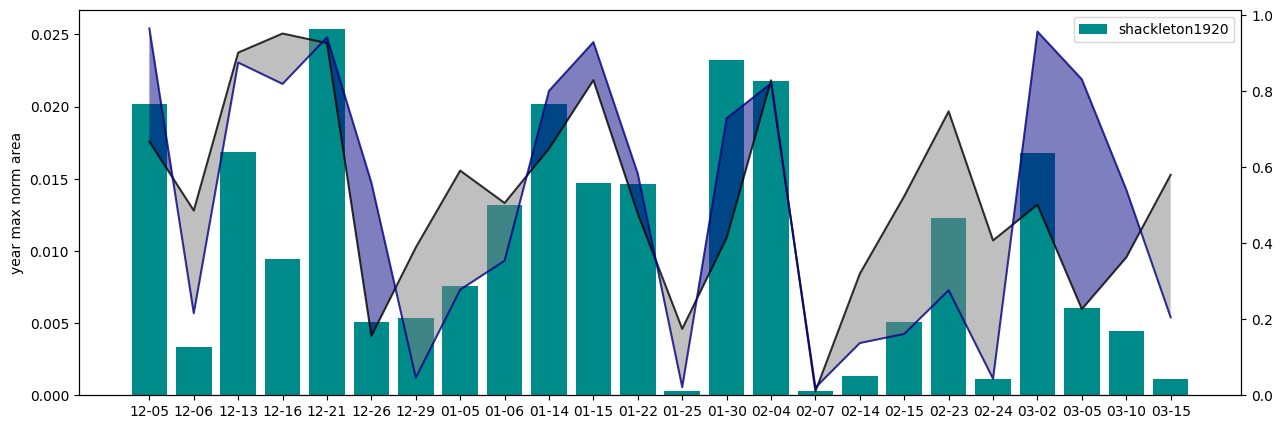

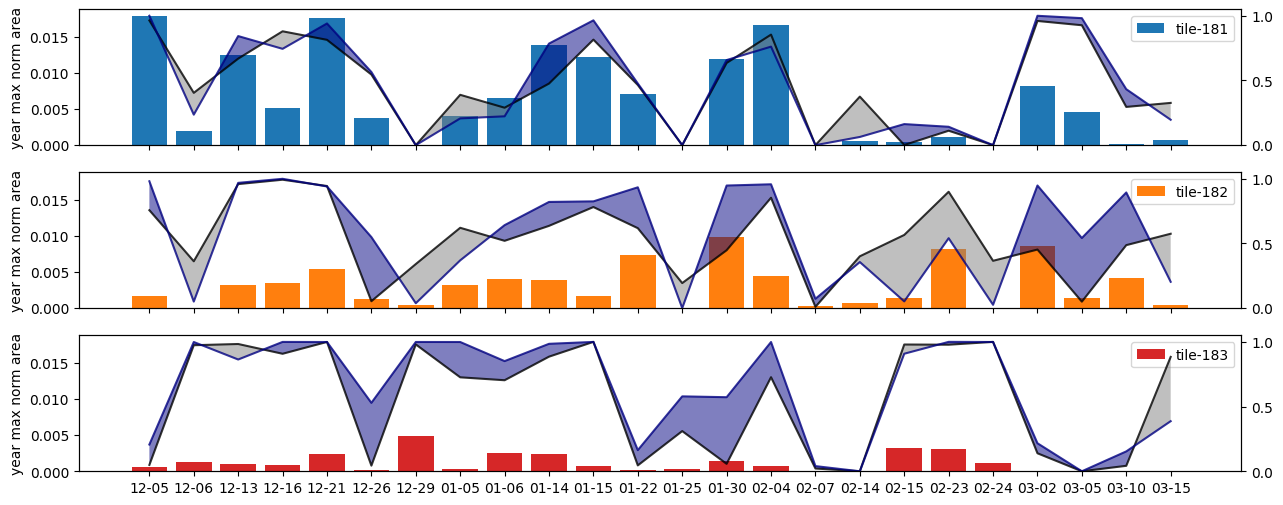

In [6]:
fig, ax = plt.subplots(figsize = (15, 5))
ax_ = ax.twinx()

#ax_.fill_between([d[5:]for d in dates], 0, image_scores, color = "gray", alpha = 0.5)
ax.bar([d[5:]for d in dates], norm_lake_areas, label = coll.name, color = "darkcyan")
ax.set_ylabel("year max norm area")
ax_.plot([d[5:]for d in dates], image_scores, color = "black", alpha = 0.8)
ax_.plot([d[5:]for d in dates], lake_scores, color = "navy", alpha = 0.8)
ax_.fill_between([d[5:]for d in dates], np.array(image_scores), np.array(lake_scores), where=np.array(lake_scores)<np.array(image_scores), facecolor='gray', interpolate=True, alpha = 0.5)  # type: ignore
ax_.fill_between([d[5:]for d in dates], np.array(image_scores), np.array(lake_scores), where=np.array(lake_scores)>np.array(image_scores), facecolor='navy', interpolate=True, alpha = 0.5)  # type: ignore

#ax.fill_between([d[5:]for d in dates], np.array(image_scores), np.array(lake_scores), facecolor='green', interpolate=True)

ax_.set_ylim(0)
ax.legend()
plt.show()


fig, axes = plt.subplots(3, 1, figsize = (15, 6), sharey = True, sharex = True)
colors = ["tab:blue", "tab:orange", "tab:red"]
for i, name in enumerate(sorted(coll.names)):
    tile_df = coll.metadata[coll.metadata["name"] == name]
    tile_df.sort_values(by = "date", axis = 0, ascending = True, inplace = True)
    
    ax = axes[i]
    ax_ = ax.twinx()
    date_list = tile_df["date"]#
    tile_norm_lake_areas = np.zeros(np.array(coll.dates).shape)
    tile_image_scores = np.zeros(np.array(coll.dates).shape)
    tile_lake_scores = np.zeros(np.array(coll.dates).shape)
    
    tile_norm_lake_areas[np.isin(coll.dates, date_list)] = np.array(tile_df["stat:alakes_reduced"])/coll.total_lake_extent
    tile_image_scores[np.isin(coll.dates, date_list)] = np.array(tile_df["stat:fashelf"])
    tile_lake_scores[np.isin(coll.dates, date_list)] = np.array(tile_df["stat:falake_extent"])



    ax.bar([d[5:] for d in coll.dates] , tile_norm_lake_areas, color = colors[i], label = name) #np.array(tile_df["stat:alakes_extent"])
    ax_.plot([d[5:] for d in coll.dates], tile_image_scores, color = "black", alpha = 0.8)
    ax_.plot([d[5:] for d in coll.dates], tile_lake_scores, color = "navy", alpha = 0.8)
    ax_.fill_between([d[5:] for d in coll.dates], tile_image_scores, tile_lake_scores, where=tile_lake_scores<tile_image_scores, facecolor='gray', interpolate=True, alpha = 0.5)  # type: ignore
    ax_.fill_between([d[5:] for d in coll.dates], tile_image_scores, tile_lake_scores, where=tile_lake_scores>=tile_image_scores, facecolor='navy', interpolate=True, alpha = 0.5)  # type: ignore

    ax_.set_ylim(0)
    ax.legend()
    ax.set_ylabel("year max norm area")
plt.show()